In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

In [447]:
def predict_trend_and_peak(df, date_col, country_col, case_col, country_name, lower_bound, extra_days, start_day=0, plot=True):
    '''
    df: the dataframe that records case info
    date_col: name of date column, must match df
    country_col: name of the country column, must match df
    case_col: name of the column we are predicting, e.g. Confirmed
    country_name: name of country to predict, must be one of the countries in country_col
    lower_bound: parameter when fitting the sigmoid model, adjust the sigmoid fit for different countries
    extra_days: number of future days to predict
    start_day: days start to have noticeable increase, default = 0
    plot: whether to plot the trend/peak
    '''
    def sigmoid(x, a, b, c): #function to be minimized
        # a = sigmoid midpoint
        # b = curve steepness (logistic growth)
        # c = max value
        return (c / (1 + np.exp(-b*(x-a))))    
    
    cols = [date_col, country_col, case_col]
    country_df = df[df[country_col] == country_name].loc[:, cols].copy()
    y = country_df.groupby(date_col).sum()[case_col][start_day:]
    x = np.arange(len(y))
    # fitting the data on the logistic function
    popt, pcov = curve_fit(sigmoid, x, y, method='dogbox', bounds=([lower_bound, 0.001, y.mean()],[60., 2.5, 10*y.max()]), maxfev=1000000)
    peakday = datetime.strftime(datetime.strptime(y.index[start_day], "%m/%d/%Y")+timedelta(days=int(popt[0])), "%m/%d/%Y")          
    print('Peakday: ', peakday)
    
    plt.figure(figsize = (16, 8))
    x_m = np.arange(len(y) + extra_days)
    y_m = sigmoid(x_m, *popt)
    print('Predictions: ')
    for i in range(1,5):
        pday = datetime.strftime(datetime.strptime(y.index[start_day], "%m/%d/%Y")+timedelta(days=len(y)+i-1), "%m/%d/%Y")
        print("%s: %d" % (pday, y_m[len(y)+i-1]))

    if plot:
        plt.plot(x, y, marker = 'o', label = 'True ' + case_col)

        plt.plot(x_m, y_m, c = 'red', label="Predicted") 
        plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 10)


        plt.xlabel("Days")
        plt.ylabel("Total")
        plt.legend(prop={'size': 15})
        plt.title(country_name+": "+case_col, size=15)
        plt.axvline(int(popt[0]) + start_day)
        plt.text(int(popt[0]) + start_day, 1, "peak: day " + peakday, size = 10)
        plt.show()

In [306]:
df = pd.read_csv("data/covid_19_data.csv")
df['Death Rate'] = df['Deaths']/df['Confirmed']
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Death Rate
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0,NaN


ObservationDate
01/22/2020      547.0
01/23/2020      639.0
01/24/2020      916.0
01/25/2020     1399.0
01/26/2020     2062.0
               ...   
04/20/2020    82747.0
04/21/2020    82779.0
04/22/2020    82790.0
04/23/2020    82804.0
04/24/2020    82819.0
Name: Confirmed, Length: 94, dtype: float64
Peakday:  02/08/2020
Predictions: 
04/25/2020: 81451
04/26/2020: 81451
04/27/2020: 81451
04/28/2020: 81451


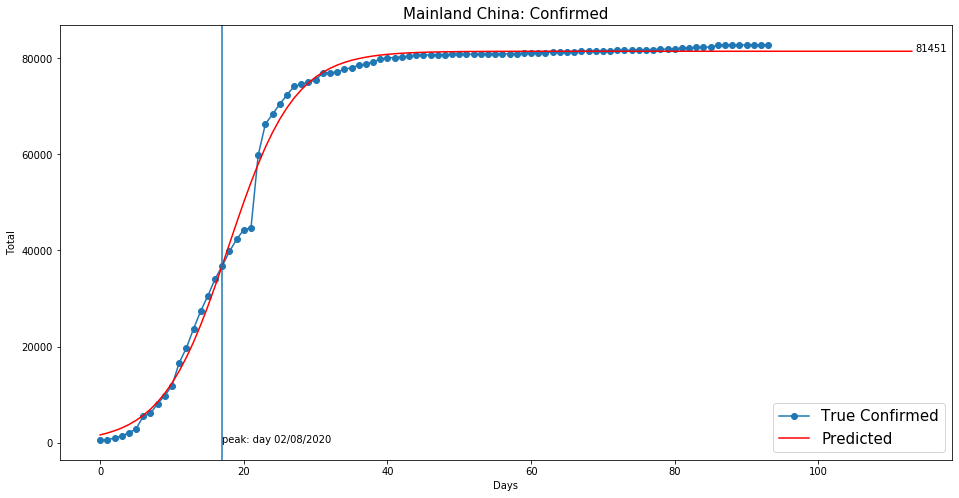

In [446]:
predict_trend_and_peak(df, 'ObservationDate', 'Country/Region', 'Confirmed', 'Mainland China', 12, 20)

Peakday:  05/12/2020
Predictions: 
05/25/2020: 916249
05/26/2020: 933833
05/27/2020: 949805
05/28/2020: 964255
Mean Error:  10318.02


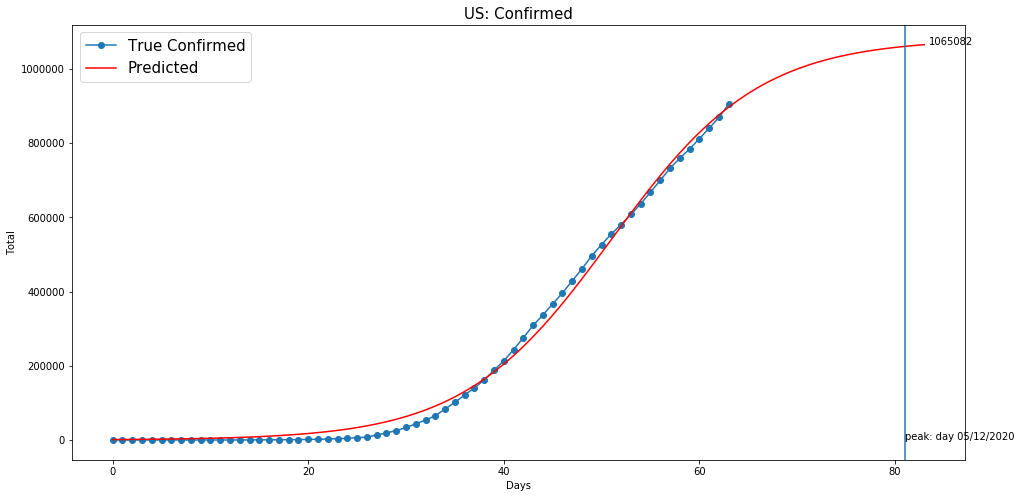

In [308]:
predict_trend_and_peak(df, 'ObservationDate', 'Country/Region', 'Confirmed', 'US', 51, 20, 30)

Peakday:  05/15/2020
Predictions: 
05/25/2020: 52794
05/26/2020: 54266
05/27/2020: 55576
05/28/2020: 56736
Mean Error:  456.72


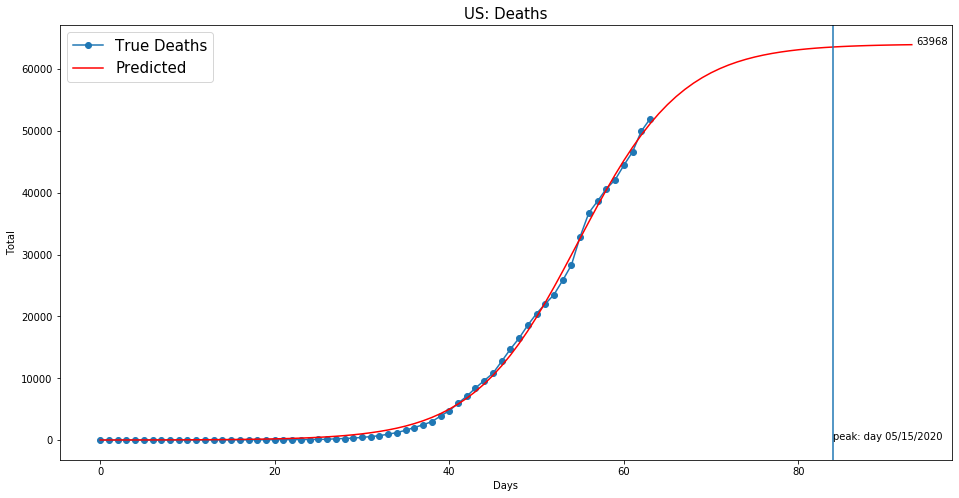

In [319]:
predict_trend_and_peak(df, 'ObservationDate', 'Country/Region', 'Deaths', 'US', 50, 30, 30)

In [490]:
hospital_df = pd.read_csv('data/Hospitalization_all_locs.csv')
hospital_known = hospital_df[hospital_df.date <= '2020-04-07']
hospital_df.head()

,Unnamed: 0,location_name,date,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,...,newICU_upper,totdea_mean,totdea_lower,totdea_upper,bedover_mean,bedover_lower,bedover_upper,icuover_mean,icuover_lower,icuover_upper
0,1,Abruzzo,2020-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Abruzzo,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Abruzzo,2020-02-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Abruzzo,2020-02-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Abruzzo,2020-02-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [499]:
hospital_df.columns

Index(['Unnamed: 0', 'location_name', 'date', 'allbed_mean', 'allbed_lower',
       'allbed_upper', 'ICUbed_mean', 'ICUbed_lower', 'ICUbed_upper',
       'InvVen_mean', 'InvVen_lower', 'InvVen_upper', 'deaths_mean',
       'deaths_lower', 'deaths_upper', 'admis_mean', 'admis_lower',
       'admis_upper', 'newICU_mean', 'newICU_lower', 'newICU_upper',
       'totdea_mean', 'totdea_lower', 'totdea_upper', 'bedover_mean',
       'bedover_lower', 'bedover_upper', 'icuover_mean', 'icuover_lower',
       'icuover_upper'],
      dtype='object')

In [496]:
def predict_trend_and_peak(df_known, df, date_col, country_col, case_col, country_name, lower_bound, extra_days, start_day=0, plot=True):
    '''
    df_known: true data
    df: true and predicted data from https://covid19.healthdata.org/united-states-of-america
    date_col: name of date column, must match df
    country_col: name of the country column, must match df
    case_col: name of the column we are predicting, e.g. Confirmed
    country_name: name of country to predict, must be one of the countries in country_col
    lower_bound: parameter when fitting the normal model, adjust the normal fit for different countries
    extra_days: number of future days to predict
    start_day: days start to have noticeable increase, default = 0
    plot: whether to plot the trend/peak
    '''
    def gaussian(x, a, mu, sigma):
        return a*np.exp(-(x-mu)**2/(2*sigma**2))
    
    y = df_known[df_known[country_col] == country_name].groupby(date_col).sum()[case_col]
    x = np.arange(len(y))
    
    # fitting the data on the gaussian distribution
    p_initial = [1.0, np.mean(y), np.std(y)]
    popt, pcov = curve_fit(gaussian, x, y, p0 = p_initial, maxfev=10000)
    print(popt)
    peakday = datetime.strftime(datetime.strptime(y.index[0], "%Y-%m-%d")+timedelta(days=int(popt[1])), "%Y-%m-%d")          
    print('Peakday: ', peakday)
    
    plt.figure(figsize = (16, 8))
    x_m = np.arange(len(y) + extra_days)
    y_m = gaussian(x_m, *popt)
    print('Predictions: ')
    for i in range(1,5):
        pday = datetime.strftime(datetime.strptime(y.index[start_day], "%Y-%m-%d")+timedelta(days=len(y)+i-1), "%Y-%m-%d")
        print("%s: %d" % (pday, y_m[len(y)+i-1]))

    
    if plot:
        plt.plot(x, y, marker = 'o', label = 'True ' + case_col)
        y_pred = df[df[country_col] == country_name].groupby(date_col).sum()[case_col]
        x_pred = np.arange(len(y_pred))
        plt.plot(x_pred, y_pred, marker = '+', label = 'Predicted by IHME')
        plt.plot(x_m, y_m, c = 'red', label="Predicted") 
        plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 10)
        plt.xlabel("Days")
        plt.ylabel("Total")
        plt.legend(prop={'size': 15})
        plt.title(country_name+": "+case_col, size=15)
        plt.axvline(int(popt[1]))
        plt.text(int(popt[1]), 1, "peak: day " + peakday, size = 10)
        plt.show()

[5937.11709709   96.45820485    7.95142232]
Peakday:  2020-04-08
Predictions: 
2020-05-08: 5927
2020-05-09: 5923
2020-05-10: 5826
2020-05-11: 5641


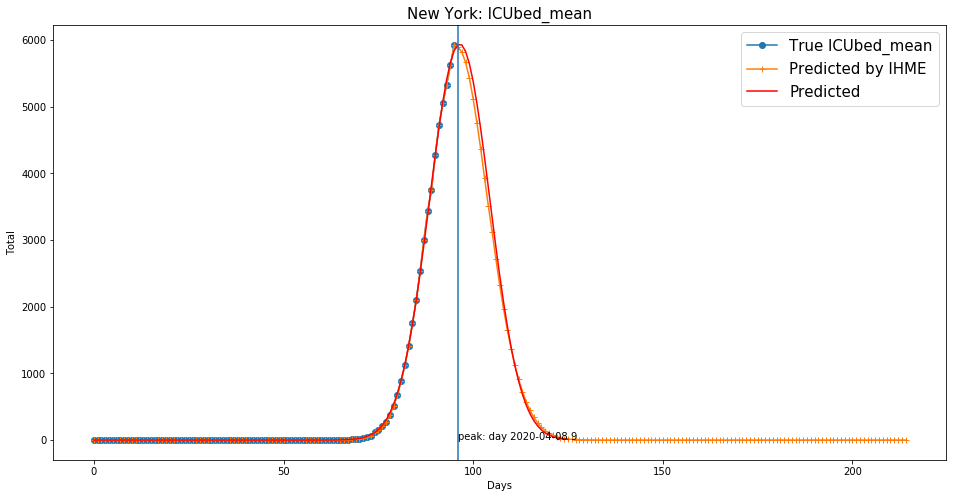

In [497]:
predict_trend_and_peak(hospital_known, hospital_df, 'date', 'location_name', 'ICUbed_mean', 'New York', 50, 30, 30)

[2.23082751e+04 9.56386604e+01 7.68964200e+00]
Peakday:  2020-04-07
Predictions: 
2020-05-08: 22283
2020-05-09: 21961
2020-05-10: 21280
2020-05-11: 20275


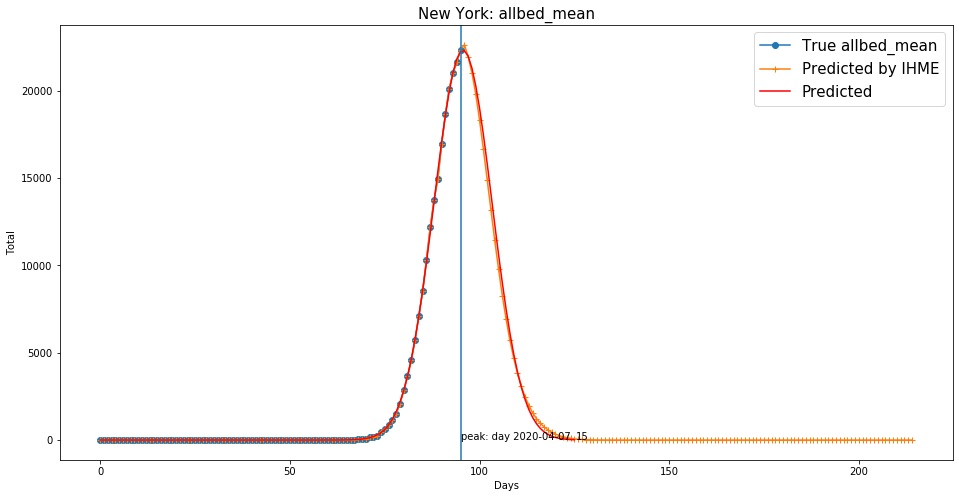

In [500]:
predict_trend_and_peak(hospital_known, hospital_df, 'date', 'location_name', 'allbed_mean', 'New York', 50, 30, 30)